In [12]:
import pandas as pd

# Load the Twitch features dataset
features_file_path = '/Users/virgiliaantonucci/Documents/Flatiron/phase_5/twitch_gamers/large_twitch_features.csv'
features_df = pd.read_csv(features_file_path)

# Display the first few rows of the dataset to understand its structure
features_df.head()


,views,mature,life_time,created_at,updated_at,numeric_id,dead_account,language,affiliate
0,7879,1,969,2016-02-16,2018-10-12,0,0,EN,1
1,500,0,2699,2011-05-19,2018-10-08,1,0,EN,0
2,382502,1,3149,2010-02-27,2018-10-12,2,0,EN,1
3,386,0,1344,2015-01-26,2018-10-01,3,0,EN,0
4,2486,0,1784,2013-11-22,2018-10-11,4,0,EN,0


In [13]:
# Load the Twitch edges dataset
edges_file_path = '/Users/virgiliaantonucci/Documents/Flatiron/phase_5/twitch_gamers/large_twitch_edges.csv'
edges_df = pd.read_csv(edges_file_path)

# Display the first few rows of the dataset to understand its structure
edges_df.head()


,numeric_id_1,numeric_id_2
0,98343,141493
1,98343,58736
2,98343,140703
3,98343,151401
4,98343,157118


In [14]:
# Checking for missing values and data types in the features dataset
features_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168114 entries, 0 to 168113
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   views         168114 non-null  int64 
 1   mature        168114 non-null  int64 
 2   life_time     168114 non-null  int64 
 3   created_at    168114 non-null  object
 4   updated_at    168114 non-null  object
 5   numeric_id    168114 non-null  int64 
 6   dead_account  168114 non-null  int64 
 7   language      168114 non-null  object
 8   affiliate     168114 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 11.5+ MB


In [17]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Assuming features_df and edges_df are already defined

# Encoding the 'language' column
label_encoder = LabelEncoder()
features_df['language_encoded'] = label_encoder.fit_transform(features_df['language'])

# Convert 'created_at' and 'updated_at' to datetime objects
features_df['created_at'] = pd.to_datetime(features_df['created_at'])
features_df['updated_at'] = pd.to_datetime(features_df['updated_at'])

# Creating new features from 'created_at' and 'updated_at'
current_date = pd.to_datetime("today")
features_df['account_age_days'] = (current_date - features_df['created_at']).dt.days
features_df['days_since_last_update'] = (current_date - features_df['updated_at']).dt.days

# Now, let's create a feature for the count of connections each streamer has
connection_counts = pd.concat([edges_df['numeric_id_1'], edges_df['numeric_id_2']]).value_counts()
features_df['connection_count'] = features_df['numeric_id'].map(connection_counts).fillna(0)

# Drop the original 'created_at', 'updated_at', and 'language' columns
features_df.drop(['created_at', 'updated_at', 'language'], axis=1, inplace=True)

# Display the updated DataFrame
features_df.head()


,views,mature,life_time,numeric_id,dead_account,affiliate,language_encoded,account_age_days,days_since_last_update,connection_count
0,7879,1,969,0,0,1,3,2815,1846,43
1,500,0,2699,1,0,0,3,4549,1850,278
2,382502,1,3149,2,0,1,3,4995,1846,122
3,386,0,1344,3,0,0,3,3201,1857,11
4,2486,0,1784,4,0,0,3,3631,1847,33


Classification Report:
               precision    recall  f1-score   support

           0       0.53      1.00      0.69     17715
           1       0.00      0.00      0.00     15908

    accuracy                           0.53     33623
   macro avg       0.26      0.50      0.35     33623
weighted avg       0.28      0.53      0.36     33623



/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

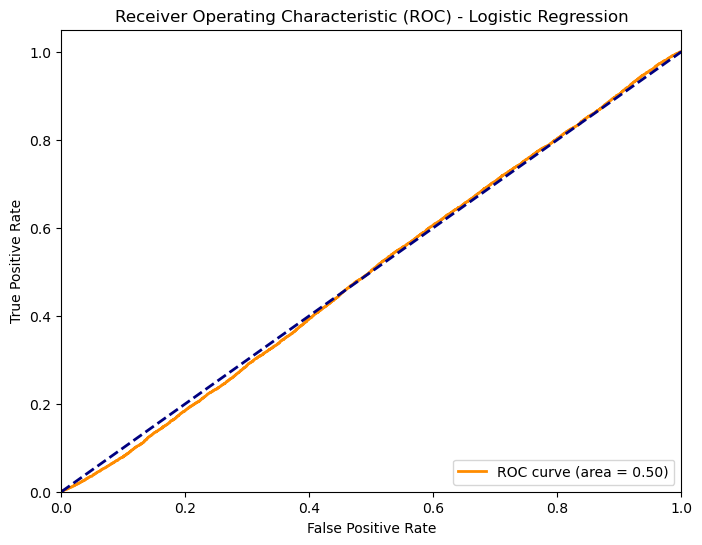

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Features and target variable
X = features_df.drop(['mature', 'numeric_id'], axis=1)
y = features_df['mature']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# ROC and AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Logistic Regression')
plt.legend(loc="lower right")
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.57      0.57     17715
           1       0.52      0.51      0.51     15908

    accuracy                           0.54     33623
   macro avg       0.54      0.54      0.54     33623
weighted avg       0.54      0.54      0.54     33623



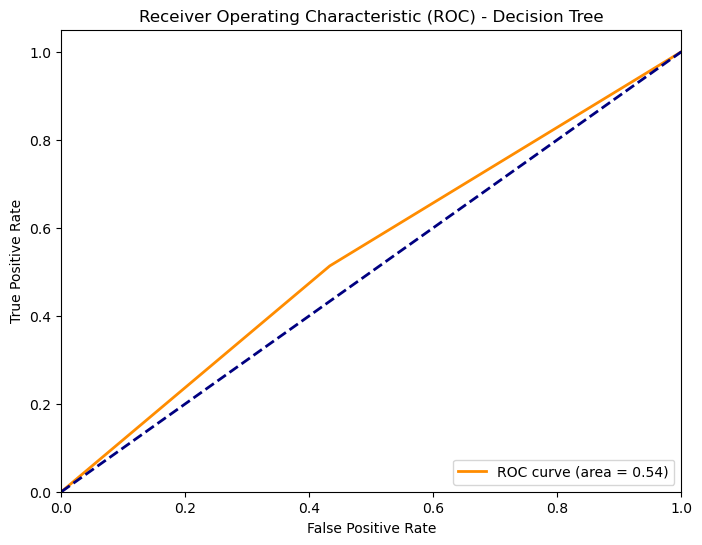

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Features and target variable
X = features_df.drop(['mature', 'numeric_id'], axis=1)  # Excluding 'numeric_id'
y = features_df['mature']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a Decision Tree classifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# ROC and AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Decision Tree')
plt.legend(loc="lower right")
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.65      0.62     17715
           1       0.57      0.52      0.54     15908

    accuracy                           0.59     33623
   macro avg       0.59      0.58      0.58     33623
weighted avg       0.59      0.59      0.59     33623



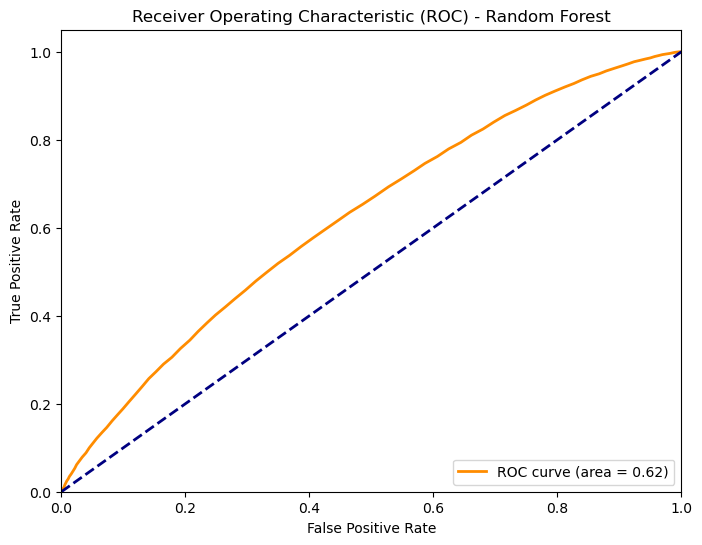

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Features and target variable
X = features_df.drop(['mature', 'numeric_id'], axis=1)  # Excluding 'numeric_id'
y = features_df['mature']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a Random Forest classifier
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# ROC and AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Random Forest')
plt.legend(loc="lower right")
plt.show()


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid: 
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
    'max_depth' : [4, 6, 8],          # Maximum number of levels in each decision tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required at each leaf node
}

# Create a base model
rf = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters Found: ")
print(grid_search.best_params_)

# Use the best estimator for further predictions
best_rf = grid_search.best_estimator_

# Continue as before with this estimator


Fitting 3 folds for each of 162 candidates, totalling 486 fits


KeyboardInterrupt: 